## <center>Air Quality Index</center>
<b><u>Table of Content</u></b>
1. [Introduction](#section1)<br>
2. [Date Set to Study](#datasetImage)<br>
3. [Pre Profiling Observations](#FirstProfilingObservation)<br>
4. [Feature Engineering Starts](#FeatureEnggStarts)<br>
5. [Post Profiling Observations](#PostProfiling)<br>
6. [Month wise temperature variation](#TemperatureVariation)<br>
7. [Relative Humidity V/S Temperature](#RHVST)<br>
8. [Factors causing high Temperature in June](#HighTFactor)<br>
9. [Actionable Items](#ActionableItem)<br>
10. [References](#References)<br>

<a id=section1></a>
## Introduction

 Air pollution has been a global problem now a days. Many countries are suffering from polluted air and global warrming due to bad air quality. The data set chosen for study is recorded from March 2004 to February 2005 in an Italian City. Various air particle's density along with temperature and humidity has been captured.

## <center>Air Quality Index</center>

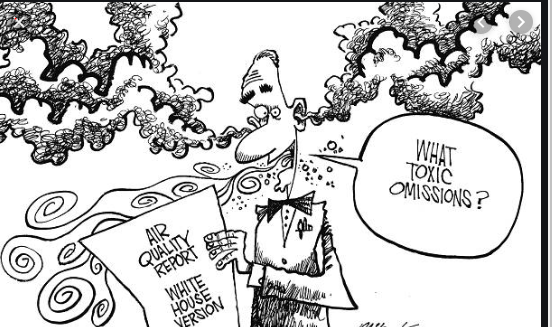


In [1]:
import pandas as pd
import numpy as np
import pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style 
pd.set_option('mode.chained_assignment', None)      # To suppress pandas warnings.


In [2]:
df=pd.read_excel("AirQualityUCI.xlsx")

In [3]:
# Get the features and their data types
df_info=df.info()
# tHe result has been shown as below:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9357 entries, 0 to 9356
Data columns (total 15 columns):
Date             9357 non-null datetime64[ns]
Time             9357 non-null object
CO(GT)           9357 non-null float64
PT08.S1(CO)      9357 non-null float64
NMHC(GT)         9357 non-null int64
C6H6(GT)         9357 non-null float64
PT08.S2(NMHC)    9357 non-null float64
NOx(GT)          9357 non-null float64
PT08.S3(NOx)     9357 non-null float64
NO2(GT)          9357 non-null float64
PT08.S4(NO2)     9357 non-null float64
PT08.S5(O3)      9357 non-null float64
T                9357 non-null float64
RH               9357 non-null float64
AH               9357 non-null float64
dtypes: datetime64[ns](1), float64(12), int64(1), object(1)
memory usage: 1.1+ MB


<a id=datasetImage></a>
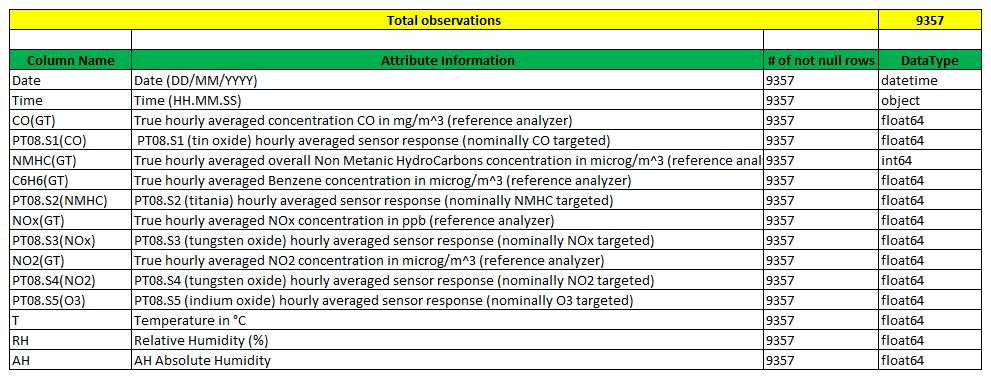

In [4]:
# profile = df.profile_report()
# profile = df.profile_report(title='Pandas Profiling Report before data profiling')
# profile.to_file(output_file="output_before_profiling.html")

<a id=FirstProfilingObservation></a>
## Observation from 1st Profiling
1. There are total 9357 records.
2. There are total 15 features has been collected.
3. Out of which 8 are numerical, 1 is categorical and 5 columns ar rejected bacuase of highly corelated as below:
    <ul>
    <li> C6H6(GT) is highly correlated with AH (ρ = 0.9845556732)</li>
    <li> PT08.S2(NMHC) is highly correlated with PT08.S1(CO) (ρ = 0.9331013408)</li>
    <li> PT08.S5(O3) is highly correlated with PT08.S2(NMHC) (ρ = 0.9099091396)</li>
    <li> RH is highly correlated with C6H6(GT) (ρ = 0.9250675945)</li>
    <li> T is highly correlated with C6H6(GT) (ρ = 0.9713702094)</li>
    </ul>
4. <u><b>All the columns has "-200" as minimum value which looks an anomaly as this value is -200 for those colums which cannot be negetive. </u></b>

<u>Note: We will replace all "-200" with Nan bacause it is suspected that all non availabe value from devices cannot be recovered and has been replaced by "-200". </u>

<a id=FeatureEnggStarts></a>
## Feature Engineering starts

In [5]:
#make a copy of data frame before any feature engineering
df_deep_copy=df.copy(deep=True)

In [6]:
# Few columns will be deleted as they are highly correlated with some 
# Delete C6H6(GT) highly correlated with AH,RH,T
# Delete PT08.S2(NMHC) highly correlated with PT08.S5(O3),PT08.S1(CO) 
df.drop(["C6H6(GT)", "PT08.S2(NMHC)"], inplace=True, axis=1)

In [7]:
df_cols=df.columns # Shows that two specified colums are dropped
df_cols

Index(['Date', 'Time', 'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'NOx(GT)',
       'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH',
       'AH'],
      dtype='object')

In [8]:
# There are many columns which ahs -200 as value. There are no other negetive values except this. Observation is "-200" are dummy
# data whhich are to replace blank or nan. Lets replace all -200 to blank or NaN
df.replace(-200,np.nan,inplace=True)

In [9]:
# Function to label the bar graphs with their lable i.e. % of missing cols
def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%s' % str(int(height/len(df)*100))+"%",
                ha='center', va='bottom', )

No handles with labels found to put in legend.


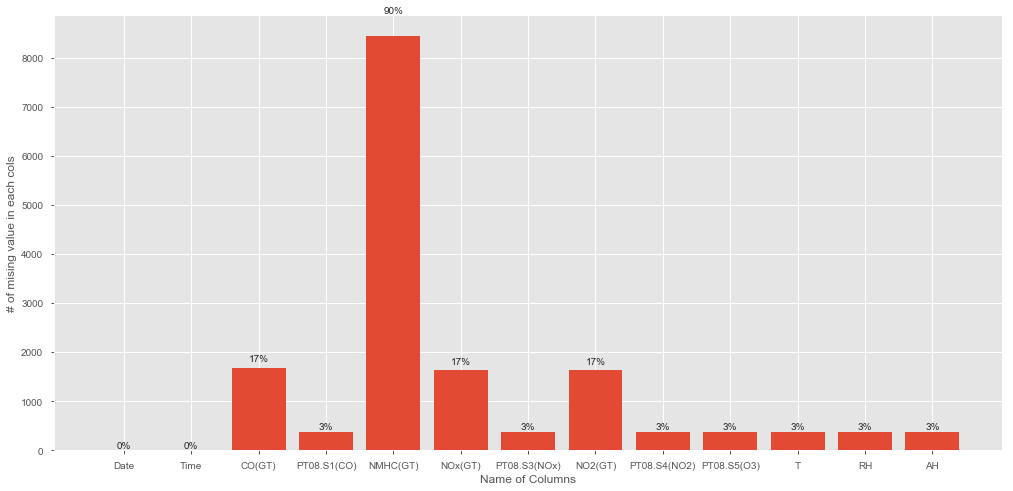

In [10]:
# Lets get the columns and # of null values in each column
x_colname_obj=[]
y_missingval_obj=[]
for eachCols in df_cols:
    #print(eachCols+"..."+ str(len(df[df[eachCols]==-200])))
    x_colname_obj.append(eachCols)
    y_missingval_obj.append(len(df[df[eachCols].isnull()]))

style.use("ggplot")
f, ax = plt.subplots(figsize=(17,8))
recs=plt.bar(x_colname_obj,y_missingval_obj)
ax.legend(fontsize = 14)
plt.xlabel("Name of Columns")
plt.ylabel("# of mising value in each cols")
autolabel(recs)
plt.show()

## Below image to show number of mising data in each columns
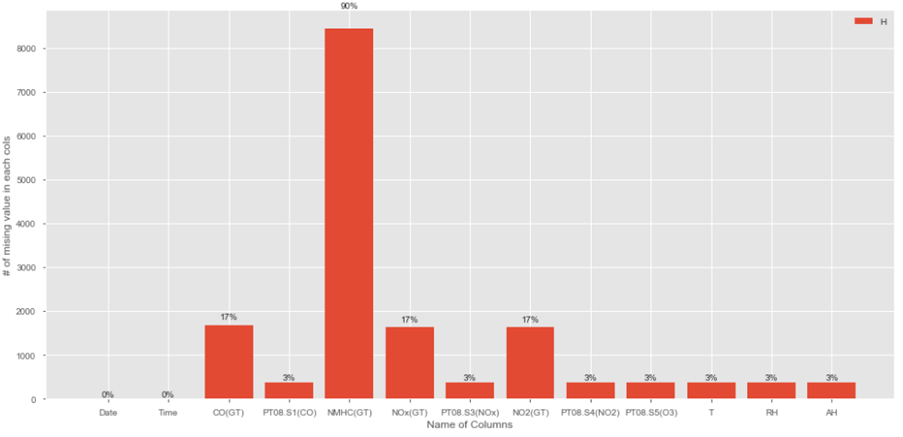

## Observation:
1. NMHC(GT) has highest number of values as Blank as 8443(90%)
2. Other few columns also have blank values.
3. Date and Times columns dont have any blank values.
4. Date has only Date and Time is only string containing time

## Next Action
1. Drop NMHC(GT) from data set.
2. Use Time series analysis to fill the missing values
3. Create new colum with concatenation of date time and make it Index, so that DateTime based interploation can be done
4. Fill the NaN values with Interpolation.

In [11]:
# Drop NHMC(GT) column from df
df.drop("NMHC(GT)", inplace=True, axis=1)

In [12]:
#Created new column with concatenated value of Date and Time
df["new_time"]=df["Date"].dt.strftime('%Y-%m-%d').astype('str') +" "+ df["Time"].astype('str')
#set the new columns as index
df.set_index("new_time",inplace=True)
df.index

Index(['2004-03-10 18:00:00', '2004-03-10 19:00:00', '2004-03-10 20:00:00',
       '2004-03-10 21:00:00', '2004-03-10 22:00:00', '2004-03-10 23:00:00',
       '2004-03-11 00:00:00', '2004-03-11 01:00:00', '2004-03-11 02:00:00',
       '2004-03-11 03:00:00',
       ...
       '2005-04-04 05:00:00', '2005-04-04 06:00:00', '2005-04-04 07:00:00',
       '2005-04-04 08:00:00', '2005-04-04 09:00:00', '2005-04-04 10:00:00',
       '2005-04-04 11:00:00', '2005-04-04 12:00:00', '2005-04-04 13:00:00',
       '2005-04-04 14:00:00'],
      dtype='object', name='new_time', length=9357)

In [13]:
df.reset_index(inplace=True)
df_null_vals=df.copy(deep=True)
df["new_time"]=pd.to_datetime(df["new_time"])
df.set_index("new_time",inplace=True)

In [14]:
#filled the NaNs with interpoltion using Time data
df.interpolate(method="time",inplace=True)

In [15]:
df.iloc[8:11]

,Date,Time,CO(GT),PT08.S1(CO),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
new_time,,,,,,,,,,,,
2004-03-11 02:00:00,2004-03-11,02:00:00,0.90,1094.00,45.0,1579.0,60.0,1276.00,619.50,10.650,59.674999,0.764819
2004-03-11 03:00:00,2004-03-11,03:00:00,0.60,1009.75,33.0,1705.0,47.0,1234.75,501.25,10.250,60.200001,0.751657
2004-03-11 04:00:00,2004-03-11,04:00:00,0.65,1011.00,21.0,1817.5,34.0,1196.75,445.25,10.075,60.474999,0.746495


In [16]:
# Lets get the columns and # of null values in each column
# df_cols=df.columns
# x_colname_obj=[]
# y_missingval_obj=[]
# for eachCols in df_cols:
#     #print(eachCols+"..."+ str(len(df[df[eachCols]==-200])))
#     x_colname_obj.append(eachCols)
#     y_missingval_obj.append(len(df[df[eachCols].isnull()]))

# style.use("ggplot")
# f, ax = plt.subplots(figsize=(17,8))
# recs=plt.bar(x_colname_obj,y_missingval_obj)
# ax.legend(fontsize = 14)
# plt.xlabel("Name of Columns")
# plt.ylabel("# of mising value in each cols")
# autolabel(recs)
# plt.show()

## After removing all NaN Data
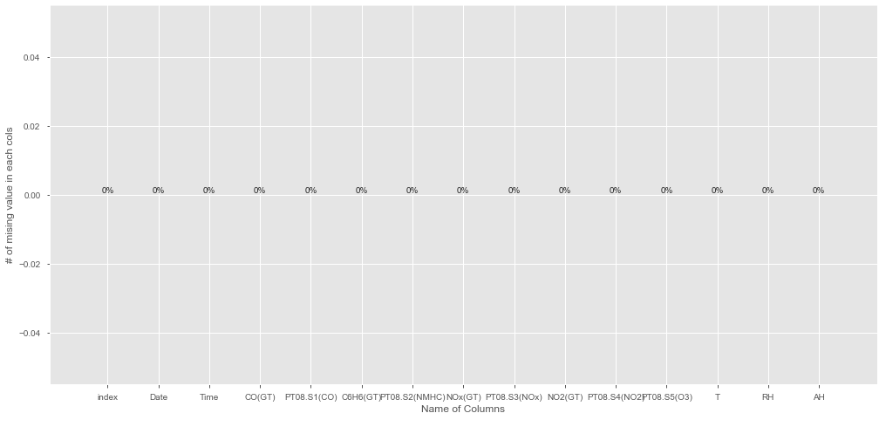

In [17]:
# after profiling the new info came as
#PT08.S5(O3) is highly correlated with PT08.S1(CO) (ρ = 0.9017304952) so dropping "PT08.S5(O3)"

df.drop("PT08.S5(O3)",inplace=True, axis=1)


In [18]:
#taking the new copy after final profiling
df_deep_copy=df.copy(deep=True)

In [19]:
# profile = df.profile_report()
# profile = df.profile_report(title='Pandas Profiling Report After data profiling')
# profile.to_file(output_file="output_after_profiling.html")

<a id=PostProfiling></a>
## After profiling and feature engineering the final data looks good and normal. Please see attached post profiling report
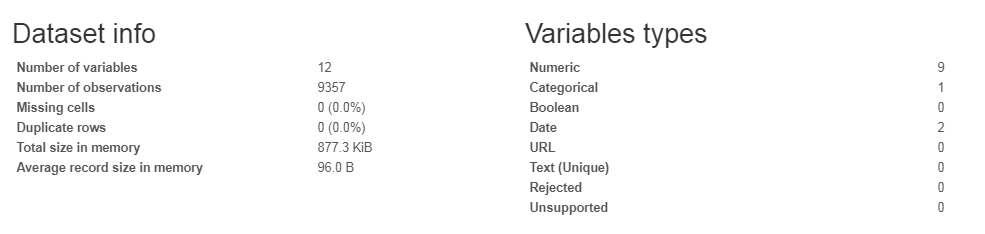

## Observations with clean data

Q1: How is the Temperature varied with the months

In [65]:
 df["month"]=df.Date.dt.month
# print(round(df.groupby('month')['T'].max()))
# print(round(df.groupby('month')['T'].min()))
# print(round(df.groupby('month')['T'].mean()))



In [21]:
# data = df.groupby('month')['T'].agg({'Low Value':'min','High Value':'max','Mean':'mean'})
# data.reset_index(inplace=True)

# ax  = data.plot(x='month', y='Mean', c='white')
# plt.fill_between(x='month',y1='Low Value',y2='High Value', data=data)

<a id=TemperatureVariation></a>
## The month wise temperature variation is as below:

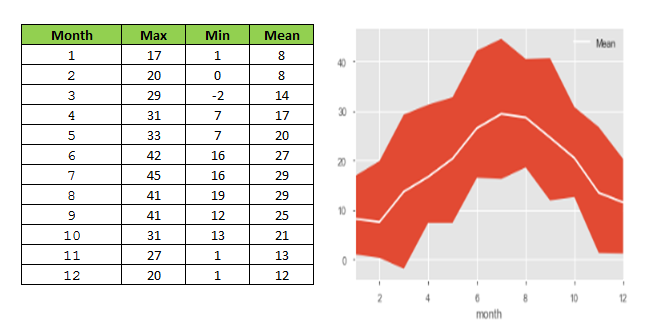

<a id=RHVST></a>
## Relative Humidity V/S Temperature

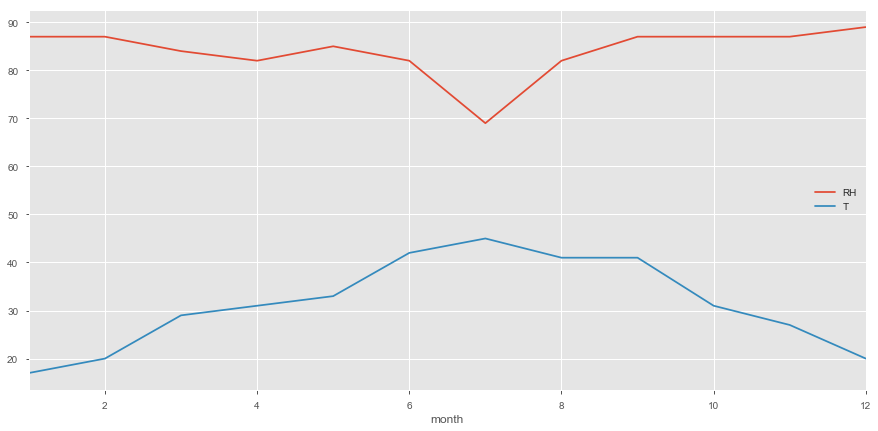

In [77]:
# print(round(df.groupby('month')['T','RH','AH'].max()))
# print(round(df.groupby('month')['T','RH','AH'].min()))
# print(round(df.groupby('month')['T','RH','AH'].mean()))

# round(df.groupby('month')['T'].max()).plot(kind='line', figsize=(15, 7), color='green')
# round(df.groupby('month')['RH'].max()).plot(kind='line', figsize=(15, 7), color='red')
# round(df.groupby('month')['AH'].max()).plot(kind='line', figsize=(15, 7), color='blue')


# df['T'].plot(kind='line', figsize=(15, 7), color='green')
# df['RH'].plot(kind='line', figsize=(15, 7), color='red')
# df['AH'].plot(kind='line', figsize=(15, 7), color='blue')

round(df.groupby('month')['RH','T'].max()).plot(kind='line', figsize=(15, 7))




<a id=HighTFactor></a>
## Factors causing high Temperature in June

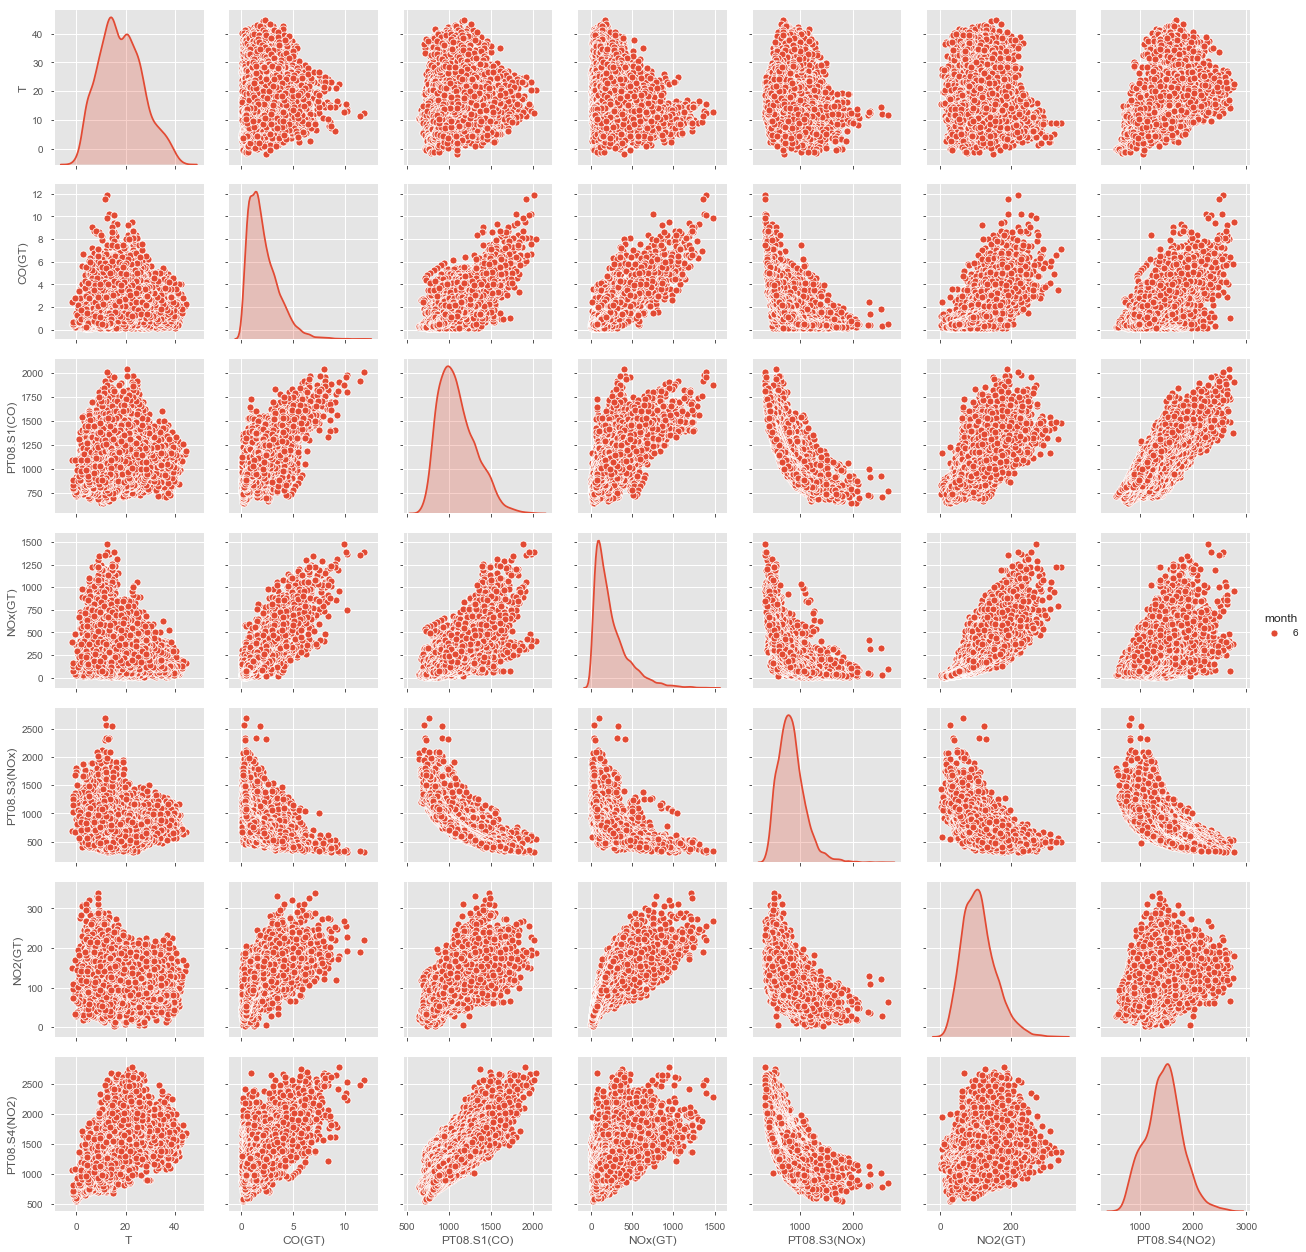

In [62]:
df[df['month']==6]
sns.pairplot(df[df['month']==6], vars=['T','CO(GT)','PT08.S1(CO)','NOx(GT)','PT08.S3(NOx)','NO2(GT)', 'PT08.S4(NO2)'],hue='month')


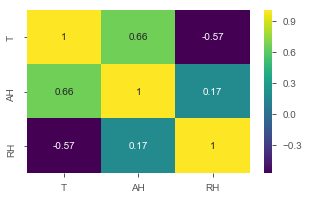

In [61]:
df_outputcols=df[['T','AH','RH']]
corr_mat = df_outputcols.corr()
plt.figure(figsize=(5,3))
sns.heatmap(corr_mat, annot=True, cmap='viridis')

<a id=ActionableItem></a>
## Actionable Items:
1. The sensor which records “NMHC(GT) ” is not working properly because almost 90% data recorded as blank or default value -200
2. May need to fine tune sensors for “CO(GT)”, “NOX(GT)”, “NO2(GT)” as around 17%  data recorded as blank or default value -200.
3. During June and July, the Relative humidity was very low, which will cause various health problems. Campaign to start awareness about these situations and its consequences.
4. Measures to be taken to prevent Tungsten quantity in atmosphere to avoid temperature rise.

<a id=References></a>
## References
1. https://archive.ics.uci.edu/ml/datasets/Air+quality
2. https://buythermopro.com/guides/low-humidity-effects-solutions/
3. https://share.upmc.com/2014/06/effects-humidity-body/
4. https://www.sciencedirect.com/science/article/abs/pii/S0263436896000273
